# [RQ6] Experience and Winning in the Premier League 

In this exercise we'll try to see if there is any relation between the average ages of the lineup of a Premier League team and his position in the Premier League table.
In other word we'll try to prove that a team with more experienced players can have an advantage over teams with younger players.

In [66]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.linear_model import LinearRegression

# Obtain a matches dataframe and clean it

In [67]:
#Load teams.json and save it as json and as dataframe
#We clean and rename the teams dataframe because we want to easily join it with another dataframe.
teams = pd.read_json(r'C:\Users\simo2\teams.json')
with open(r'C:\Users\simo2\teams.json') as data_file:    
    data = json.load(data_file)
teams = pd.io.json.json_normalize(data) 
teams = teams[teams.type =="club"] # we don't want national teams
teams = teams[["name", "area.name", "wyId"]]
teams.rename(columns={"area.name":'area','wyId':'currentTeamId'},inplace = True)
teams = teams[(teams['area'] == 'England') | (teams['area'] == 'Wales')]
teams.head()

,name,area,currentTeamId
0,Newcastle United,England,1613
8,Huddersfield Town,England,1673
19,Swansea City,Wales,10531
26,AFC Bournemouth,England,1659
27,Brighton & Hove Albion,England,1651


# Obtain a players dataframe and clean it

In [68]:
#Load players.json and save it as a dataframe.
#Clean the dataframe,defining a function that converts birthDate to age and apply to the birthDate column of players dataset

players = pd.read_json(r'C:\Users\simo2\Downloads\players.json')
players = players[['birthDate','currentTeamId','shortName','wyId']]
def convert_age(s):
    age =(pd.to_datetime('today').year-pd.to_datetime(s).year)
    return age
players['birthDate'] = players['birthDate'].apply(convert_age)
players.rename(columns={'birthDate': 'age'}, inplace=True)
players.head()

,age,currentTeamId,shortName,wyId
0,30,4502,H. Tekin,32777
1,20,3775,M. Sarr,393228
2,21,3772,O. Mandanda,393230
3,29,683,A. N'Diaye,32793
4,20,2975,I. Konat\u00e9,393247


# Merging the two dataframes

In [69]:
#Merge players and teams dataframes and clean it
mergedDataframe = (pd.merge(players, teams, on='currentTeamId'))
mergedDataframe_players = mergedDataframe[['age','name','wyId','shortName']]
mergedDataframe_players.head()

,age,name,wyId,shortName
0,30,Tottenham Hotspur,36,T. Alderweireld
1,32,Tottenham Hotspur,48,J. Vertonghen
2,27,Tottenham Hotspur,54,C. Eriksen
3,29,Tottenham Hotspur,8292,D. Rose
4,26,Tottenham Hotspur,8717,H. Kane


# Creating a new dataframe with the appearances of each player

We want to determine the average age of the lineups of each team.
So we decided to rank all the players of each team by their lineup appearances and to take into consideration only the ages of the eleven players for each team that have the highest number of appearances. 

In [70]:
#Load the matches.json dataset and create a dictionary of players.Each player has as a value the times in which he was in the lineup during the Season
#Convert the dictionary to dataframe and merge it to the mergedDataframe_players
#Sort the new Dataframe by the Age keeping costant the teams

with open(r'C:\Users\simo2\OneDrive\Desktop\matches_England.json') as json_data:
    json_matches = json.load(json_data)
dictionary_of_players={}    
for i in range(len(json_matches)):
    list_keys=[*(json_matches[i]['teamsData'])]
    for key in list_keys:
        for j in range(11):
            Player=json_matches[i]['teamsData'][key]['formation']['lineup'][j]['playerId']
            
            if Player not in dictionary_of_players:
                dictionary_of_players[Player]=1
            else:   
                dictionary_of_players[Player]+=1 
Players_lineup = pd.DataFrame(dictionary_of_players.items(), columns=['wyId', 'Values'])
New_dataframe = (pd.merge(mergedDataframe_players,Players_lineup,on = 'wyId'))          

New_dataframe =New_dataframe.sort_values(by=['name','Values'],ascending=[True, False])
New_dataframe.rename(columns={"Values":'Appearances'},inplace = True)
New_dataframe.head()

,age,name,wyId,shortName,Appearances
352,32,AFC Bournemouth,8726,A. Begovi\u0107,38
362,24,AFC Bournemouth,134102,N. Ak\u00e9,37
355,33,AFC Bournemouth,9285,C. Daniels,34
354,34,AFC Bournemouth,9279,S. Francis,31
360,28,AFC Bournemouth,9277,S. Cook,31


# Create a dictionary which stores the average lineup ages of all the premier league teams using the dataframe with the appearances

In [71]:
#Reset the index and clean the dataframe
#Calculate the average age of all Premier League teams using a dictionary
New_dataframe = New_dataframe.reset_index ()
del New_dataframe['index']
dic_avg_age_teams = {}
total = 0
count = 0

try:
    for i in range(len(New_dataframe)):
        if New_dataframe['name'][i] == New_dataframe['name'][i+1] and New_dataframe['name'][i] not in dic_avg_age_teams:
            total += New_dataframe['age'][i]
            count += 1
        if New_dataframe['name'][i] != New_dataframe['name'][i+1] and New_dataframe['name'][i] not in dic_avg_age_teams:
            total += New_dataframe['age'][i]
            count += 1
        
        if count == 11 and New_dataframe['name'][i] not in dic_avg_age_teams:
            dic_avg_age_teams[New_dataframe['name'][i]]= total/11
            total = 0
            count = 0
except KeyError:
    pass      
dic_avg_age_teams

{'AFC Bournemouth': 27.636363636363637,
 'Arsenal': 29.0,
 'Brighton & Hove Albion': 29.90909090909091,
 'Burnley': 29.727272727272727,
 'Chelsea': 28.09090909090909,
 'Crystal Palace': 29.09090909090909,
 'Everton': 27.545454545454547,
 'Huddersfield Town': 28.545454545454547,
 'Leicester City': 30.09090909090909,
 'Liverpool': 27.363636363636363,
 'Manchester City': 28.90909090909091,
 'Manchester United': 29.636363636363637,
 'Newcastle United': 28.181818181818183,
 'Southampton': 27.09090909090909,
 'Stoke City': 30.272727272727273,
 'Swansea City': 28.90909090909091,
 'Tottenham Hotspur': 27.545454545454547,
 'Watford': 31.181818181818183,
 'West Bromwich Albion': 29.818181818181817,
 'West Ham United': 30.272727272727273}

# Calculating the Premier League final table with a dictionary

In [72]:
#Load matches.json as a dataframe,clean it and create a dictionary that pairs each team with their points in Premier League season 2017-2018

matches = pd.read_json(r"C:\Users\simo2\OneDrive\Desktop\matches_England.json")
matches = matches[["status", "gameweek", "winner", "label" ]] 
matches = matches[matches.status =="Played"] 
del matches["status"] 
matches = matches.sort_values(by=["gameweek"]) 
matches.index = range(len(matches.index)) 
teams = teams.reset_index ()
del teams['index']
dict_of_teams = {}
for i in range(len(teams)):
    team = teams.iloc[i,0]
    wyId = teams.iloc[i,2]
    dict_of_teams[team]  = 0
    for i in range(len(matches)):
        if team in matches['label'][i] and matches['winner'][i]== wyId:
            dict_of_teams[team] += 3
        if team in matches['label'][i] and matches['winner'][i]== 0:
            dict_of_teams[team] += 1
dict_of_teams            

{'Newcastle United': 44,
 'Huddersfield Town': 37,
 'Swansea City': 33,
 'AFC Bournemouth': 44,
 'Brighton & Hove Albion': 41,
 'Burnley': 54,
 'Leicester City': 47,
 'West Ham United': 42,
 'Stoke City': 33,
 'Watford': 39,
 'Everton': 48,
 'West Bromwich Albion': 31,
 'Manchester City': 100,
 'Tottenham Hotspur': 77,
 'Crystal Palace': 44,
 'Southampton': 36,
 'Liverpool': 75,
 'Chelsea': 70,
 'Manchester United': 81,
 'Arsenal': 63}

# Obtaining a final dataframe from the two dictionaries

In [73]:
#Convert the two dictionaries to two dataframes and merge them

dataframe_avg_age= pd.DataFrame(dic_avg_age_teams.items(), columns=['name', 'avgage'])
dataframe_points = pd.DataFrame(dict_of_teams.items(), columns=['name', 'points'])
dataframe_points = dataframe_points.sort_values('name') 
merged_dataframe_points_avg_age= pd.merge(dataframe_avg_age,dataframe_points,on = 'name') 
merged_dataframe_points_avg_age

,name,avgage,points
0,AFC Bournemouth,27.636364,44
1,Arsenal,29.000000,63
2,Brighton & Hove Albion,29.909091,41
3,Burnley,29.727273,54
4,Chelsea,28.090909,70
5,Crystal Palace,29.090909,44
6,Everton,27.545455,48
7,Huddersfield Town,28.545455,37
8,Leicester City,30.090909,47
9,Liverpool,27.363636,75


# Plotting the dataframe

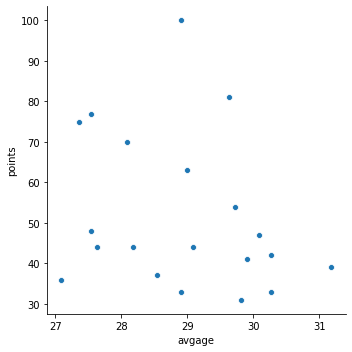

In [74]:
#Plot the dataframe

sns.relplot(x="avgage", y="points", data=merged_dataframe_points_avg_age)

We see no relation between the average ages of players of a team and the point that the team gained in the season.

# Linear regression

In [75]:
X = merged_dataframe_points_avg_age['avgage'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = merged_dataframe_points_avg_age['points'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

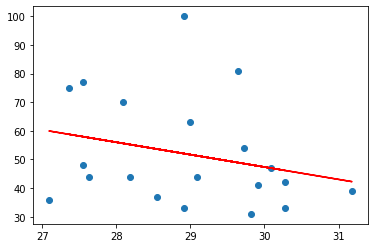

In [76]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()